# Datasets in ``salad``

This is a test notebook that will later hold demos for a subpackage of `salad`

In [9]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

## Digits Datasets

A standard benchmark for domain adaptation is digit classification. In ``salad.datasets``, it is easy to get access to this standard benchmark.

In [2]:
from salad.datasets import DigitsLoader
from salad.utils import panelize

We currently implemented unified loading functions for four different benchmarks.

In [10]:
from salad.datasets import MNIST, USPS, SVHN, Synth

mnist = MNIST('/tmp/digits')
usps  = USPS('/tmp/digits')
svhn  = SVHN('/tmp/digits')
synth = Synth('/tmp/digits')

Extracting /tmp/digits/zip.train.gz
Done!
Extracting /tmp/digits/synth_train_32x32.mat?raw=true


In [18]:
! sudo mv /tmp/digits/zip.train.gz /tmp/data

Accessing them is also possible directy by ``DigitsLoader``, which subclasses the usual ``torch.utils.data.DataLoader``:

In [19]:
dataset_names = ['mnist', 'usps', 'synth', 'svhn']
data = DigitsLoader('/tmp/data', dataset_names, shuffle=True, batch_size = 64, normalize=False, download=True)

Extracting /tmp/data/zip.train.gz
Extracting /tmp/data/synth_train_32x32.mat?raw=true
Using downloaded and verified file: /tmp/data/train_32x32.mat


In [20]:
for batch in data:
    
    for (x,y), name in zip(batch, dataset_names):
        
        print(name, x.size(), y.dtype, np.unique(y.numpy()))
    
    break

mnist torch.Size([64, 3, 32, 32]) torch.int64 [0 1 2 3 4 5 6 7 8 9]
usps torch.Size([64, 3, 32, 32]) torch.int64 [0 1 2 3 4 5 6 7 8 9]
synth torch.Size([64, 3, 32, 32]) torch.int64 [0 1 2 3 4 5 6 7 8 9]
svhn torch.Size([64, 3, 32, 32]) torch.int64 [0 1 2 3 4 5 6 7 8 9]


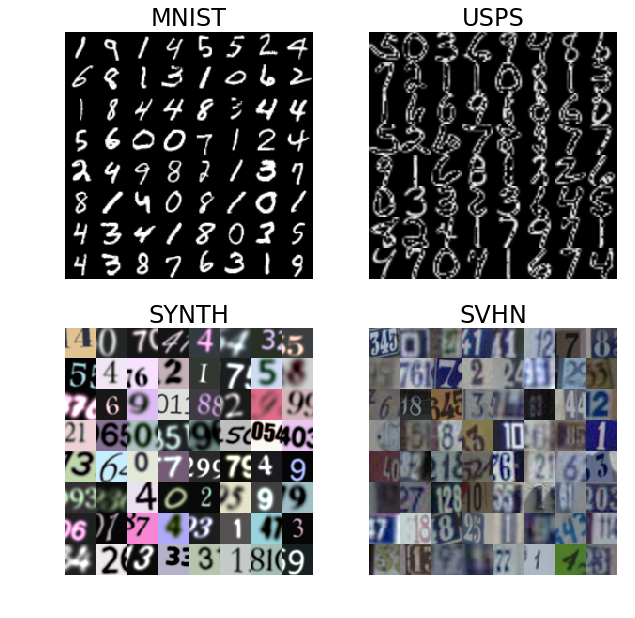

In [21]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()

for batch in data:
    
    for (x,y), ax, name in zip(batch, axes, dataset_names):
        
        ax.imshow(panelize(x.numpy()))
        ax.set_title(name.upper())
        ax.axis('off')
        
    break
    
plt.show()

For training adaptation models, it is generally a good idea to normalize the images in some way prior to feeding them into a neural network.
``salad`` provide some means of doing this in a standardized way. In particular, it is easy to check statistics of the dataset:

In [22]:
default_normalization = {}

data_normalized = DigitsLoader('/tmp/data', dataset_names, shuffle=True, batch_size = 200, normalize = True)

for dataset in data_normalized.datasets:
    
    samples = np.concatenate([x.numpy() for x,_ in dataset])
    print(samples.mean(axis=(0,2,3)), samples.std(axis=(0,2,3)))

Normalize data
Normalize data
Extracting /tmp/data/zip.train.gz
Normalize data
Extracting /tmp/data/synth_train_32x32.mat?raw=true
Normalize data
Using downloaded and verified file: /tmp/data/train_32x32.mat
[9.431913e-07 9.431913e-07 9.431913e-07] [1.0009959 1.0009959 1.0009959]
[-3.8915885e-05 -3.8915885e-05 -3.8915885e-05] [1.0014577 1.0014577 1.0014577]
[-0.02842944 -0.03311951 -0.03919533] [1.0014    1.0049554 0.9992065]
[-9.3001610e-05 -1.5507564e-04  2.3352888e-05] [1.0297986 1.0292652 1.0348581]


In [23]:
from salad.datasets import NoiseLoader
from salad.datasets.transforms import SaltAndPepper

loader = NoiseLoader('/tmp/data', 'synth', collate = 'stack',
                        noisemodels=[lambda x : x, SaltAndPepper(0.05), SaltAndPepper(0.10), SaltAndPepper(0.15)],
                        batch_size = 32, shuffle = True, normalize=False)

Extracting /tmp/data/synth_train_32x32.mat?raw=true
Extracting /tmp/data/synth_train_32x32.mat?raw=true
Extracting /tmp/data/synth_train_32x32.mat?raw=true
Extracting /tmp/data/synth_train_32x32.mat?raw=true


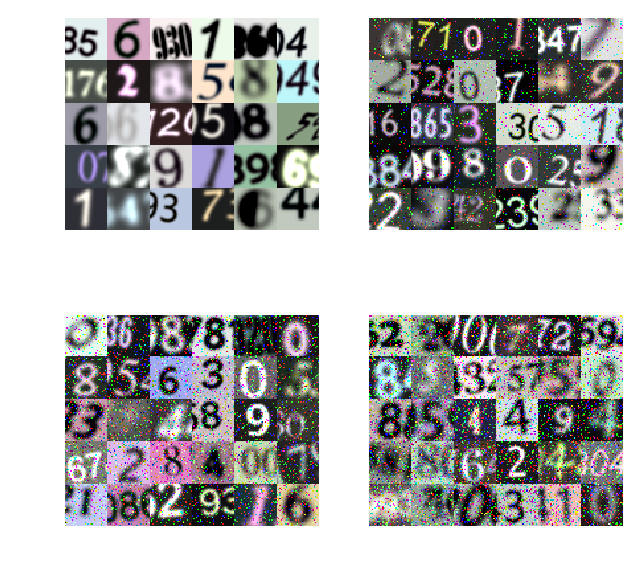

In [24]:
from salad.utils import panelize

fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.flatten()

for batch in loader:
    
    for (x,y), ax in zip(batch, axes):
        
        ax.imshow(panelize(x.numpy()))
        ax.axis('off')
        
    break
    
plt.show()

The normalization values can be found in ``salad.datasets.transforms``.

## Office-31 Datasets

In [6]:
from salad.datasets import OfficeDataset, OfficeDataLoader

loader = OfficeDataLoader('/gpfs01/bethge/home/sschneider/data/office/', batch_size = 16, shuffle=True)

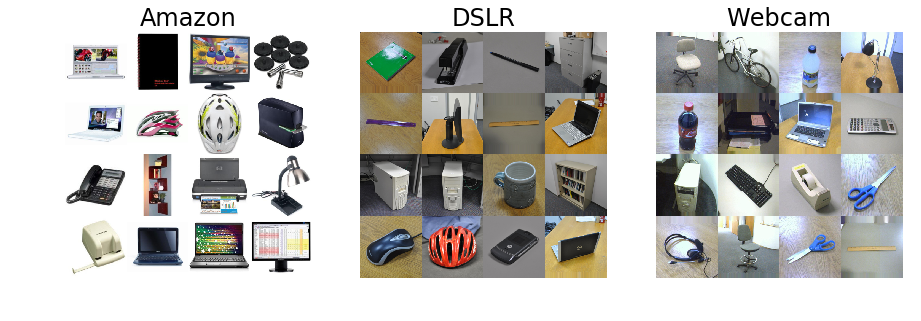

In [8]:
from salad.utils import panelize
import seaborn as sns

sns.set_context("poster")

for batch in loader:
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    
    for ax, (img,_), name in zip(axes.flatten(), batch, loader.names):
        ax.imshow(panelize(img.numpy()))
        ax.set_title(name)
        ax.axis("off")

    plt.show()
    
    break

## Toy Datasets

The ``salad.datasets`` package also provides a loader for toy datasets.

In [7]:
from salad.datasets import ToyDatasetLoader

loader_stacked = ToyDatasetLoader(augment = False, collate='stack', batch_size = 2048, seed=1306)
loader_concat  = ToyDatasetLoader(augment = False, collate='cat', batch_size = 2048, seed=1306)

A stacked loader returns a tuples containing the return values of the individual datasets:

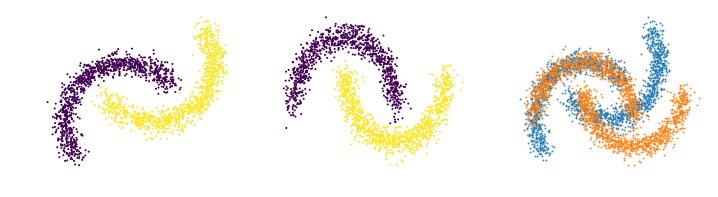

In [9]:
for (xs,ys), (xt,yt) in loader_stacked:
    
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.scatter(*xs.transpose(1,0), c = ys, s= 1)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.scatter(*xt.transpose(1,0), c = yt, s = 1)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.scatter(*xs.transpose(1,0), s=1, alpha = .75)
    plt.scatter(*xt.transpose(1,0), s=1, alpha = .75)  
    plt.axis('off')
    
    break

plt.show()